In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [2]:
from pathlib import Path

# Configurable parts
SYMBOL = "USDJPY"
DOLLAR_THRESHOLD = "115009542m"

START_DATE = "20210101"
END_DATE = "20241231"

# Build base name
RESAMPLED_NAME = f"{SYMBOL}-{DOLLAR_THRESHOLD}-dollar-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}-processed.pkl"

In [3]:
EVENT_NAME = 'cusum_filter'
DIRECTION_LABEL_DIR = BASE_DIR / "direction_labels"
DIRECTION_LABEL_DIR.mkdir(parents=True, exist_ok=True)
DIRECTION_LABEL_FILE_PATH = DIRECTION_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}.pkl"

In [4]:
%%time
df = pd.read_pickle(PROCESSED_FILE_PATH)

CPU times: user 607 μs, sys: 24.1 ms, total: 24.7 ms
Wall time: 24.2 ms


In [5]:
df.shape

(832151, 48)

In [6]:
df.head()

,open,high,low,close,volume,spread,close_delta,close_return,close_log_return,ret_mean_5,...,dom,month,hour_sin,hour_cos,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-04 02:13:07.071,103.0510,103.0585,103.0305,103.0525,1.118770e+12,0.003031,0.0025,0.000024,0.000024,-0.000121,...,4,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025
2021-01-04 02:22:14.974,103.0520,103.0655,103.0365,103.0365,1.117670e+12,0.002791,-0.0160,-0.000155,-0.000155,-0.000082,...,4,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025
2021-01-04 02:29:58.781,103.0370,103.0455,103.0090,103.0195,1.120180e+12,0.002957,-0.0170,-0.000165,-0.000165,-0.000072,...,4,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025
2021-01-04 02:39:51.245,103.0185,103.0355,102.9995,103.0145,1.118270e+12,0.002706,-0.0050,-0.000049,-0.000049,-0.000075,...,4,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025
2021-01-04 02:48:03.646,103.0140,103.0220,102.9675,103.0035,1.117380e+12,0.002347,-0.0110,-0.000107,-0.000107,-0.000090,...,4,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025


In [7]:
import numpy as np

df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df['log_volume'] = np.log1p(df['volume'])
df = df.dropna()

In [8]:
df.head()

,open,high,low,close,volume,spread,close_delta,close_return,close_log_return,ret_mean_5,...,month,hour_sin,hour_cos,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos,log_return
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-04 02:22:14.974,103.0520,103.0655,103.0365,103.0365,1.117670e+12,0.002791,-0.016,-0.000155,-0.000155,-0.000082,...,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025,-0.000155
2021-01-04 02:29:58.781,103.0370,103.0455,103.0090,103.0195,1.120180e+12,0.002957,-0.017,-0.000165,-0.000165,-0.000072,...,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025,-0.000165
2021-01-04 02:39:51.245,103.0185,103.0355,102.9995,103.0145,1.118270e+12,0.002706,-0.005,-0.000049,-0.000049,-0.000075,...,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025,-0.000049
2021-01-04 02:48:03.646,103.0140,103.0220,102.9675,103.0035,1.117380e+12,0.002347,-0.011,-0.000107,-0.000107,-0.000090,...,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025,-0.000107
2021-01-04 02:58:09.056,103.0045,103.0125,102.9835,102.9965,1.117240e+12,0.002308,-0.007,-0.000068,-0.000068,-0.000109,...,1,0.5,0.866025,0.0,1.0,0.724793,0.688967,0.5,0.866025,-0.000068


## Calculate Daily Volatility

In [9]:
vol = df['log_return'].rolling(window=10).std()
vol.mean()

np.float64(0.0001786505631316061)

## Get Events Start Time (t0)

In [10]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def get_tevents_optimized(data: pd.Series, threshold: float) -> pd.DatetimeIndex:
    # get tEvents using CUSUM filter
    values = data.values
    timestamps = data.index

    s_pos = np.zeros_like(values)
    s_neg = np.zeros_like(values)

    t_events_mask = np.zeros_like(values, dtype=bool)

    cum_pos, cum_neg = 0.0, 0.0

    for i in tqdm(range(len(values))):
        cum_pos = max(0.0, cum_pos + values[i])
        cum_neg = min(0.0, cum_neg + values[i])
        s_pos[i] = cum_pos
        s_neg[i] = cum_neg

        if cum_pos > threshold:
            t_events_mask[i] = True
            cum_pos = 0.0
        if cum_neg < -threshold:
            t_events_mask[i] = True
            cum_neg = 0.0

    return timestamps[t_events_mask]


In [11]:
%%time

t_events = get_tevents_optimized(df['log_return'].iloc[1:], threshold=vol.mean())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 832149/832149 [00:00<00:00, 3309293.97it/s]

CPU times: user 253 ms, sys: 11.5 ms, total: 264 ms
Wall time: 264 ms


In [12]:
t_events

DatetimeIndex(['2021-01-04 02:39:51.245000', '2021-01-04 03:10:16.043000',
               '2021-01-04 03:35:34.353000', '2021-01-04 03:46:15.759000',
               '2021-01-04 04:22:33.521000', '2021-01-04 04:36:59.838000',
               '2021-01-04 05:00:50.849000', '2021-01-04 05:14:08.409000',
               '2021-01-04 05:20:16.974000', '2021-01-04 05:50:18.483000',
               ...
               '2024-12-30 21:06:58.409000', '2024-12-30 21:32:33.781000',
               '2024-12-30 21:45:09.215000', '2024-12-30 21:48:03.683000',
               '2024-12-30 22:57:51.659000', '2024-12-30 23:10:19.118000',
               '2024-12-30 23:15:58.082000', '2024-12-30 23:36:09.864000',
               '2024-12-30 23:40:21.853000', '2024-12-30 23:47:00.978000'],
              dtype='datetime64[ns]', name='timestamp', length=318982, freq=None)

In [13]:
df.loc[t_events]

,open,high,low,close,volume,spread,close_delta,close_return,close_log_return,ret_mean_5,...,month,hour_sin,hour_cos,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos,log_return
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-04 02:39:51.245,103.0185,103.0355,102.9995,103.0145,1.118270e+12,0.002706,-0.0050,-0.000049,-0.000049,-0.000075,...,1,0.500000,0.866025,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025,-0.000049
2021-01-04 03:10:16.043,102.9965,102.9970,102.9715,102.9850,1.117470e+12,0.002073,-0.0115,-0.000112,-0.000112,-0.000100,...,1,0.707107,0.707107,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025,-0.000112
2021-01-04 03:35:34.353,102.9880,102.9950,102.9680,102.9680,1.118530e+12,0.002547,-0.0185,-0.000180,-0.000180,-0.000090,...,1,0.707107,0.707107,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025,-0.000180
2021-01-04 03:46:15.759,102.9670,102.9775,102.9380,102.9430,1.119830e+12,0.002287,-0.0250,-0.000243,-0.000243,-0.000118,...,1,0.707107,0.707107,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025,-0.000243
2021-01-04 04:22:33.521,102.9570,103.0080,102.9540,103.0000,1.117600e+12,0.002342,0.0435,0.000423,0.000422,0.000029,...,1,0.866025,0.500000,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025,0.000422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 23:10:19.118,156.9105,156.9640,156.9090,156.9635,7.369500e+11,0.022684,0.0545,0.000347,0.000347,0.000132,...,12,-0.258819,0.965926,0.0,1.0,-0.201299,0.979530,-2.449294e-16,1.000000,0.000347
2024-12-30 23:15:58.082,156.9640,157.0270,156.9575,157.0140,7.367500e+11,0.016922,0.0505,0.000322,0.000322,0.000169,...,12,-0.258819,0.965926,0.0,1.0,-0.201299,0.979530,-2.449294e-16,1.000000,0.000322
2024-12-30 23:36:09.864,157.0330,157.0335,156.9610,156.9730,7.343700e+11,0.008389,-0.0595,-0.000379,-0.000379,0.000012,...,12,-0.258819,0.965926,0.0,1.0,-0.201299,0.979530,-2.449294e-16,1.000000,-0.000379


## Calculate Target Volatility (trgt)
This will be used for the calculation of dynamic TP/SL

In [14]:
def get_daily_vol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    #bp()
    df0=df0[df0>0]
    #bp()
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

In [15]:
%%time
daily_vol = get_daily_vol(df['close'])

CPU times: user 97.6 ms, sys: 6.62 ms, total: 104 ms
Wall time: 104 ms


In [16]:
trgt = daily_vol.reindex(t_events, method='ffill')
trgt.describe()

count    318889.000000
mean          0.001397
std           0.001005
min           0.000110
25%           0.000798
50%           0.001145
75%           0.001673
max           0.013971
Name: dailyVol, dtype: float64

In [17]:
from ta.volatility import AverageTrueRange

def get_atr(df, window=60):
    atr = AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=window)
    return atr.average_true_range().rename(f"atr{window}")

CPU times: user 1.5 s, sys: 35.5 ms, total: 1.53 s
Wall time: 1.54 s


<Axes: title={'center': 'ATR on Dollar Bars'}, xlabel='timestamp'>

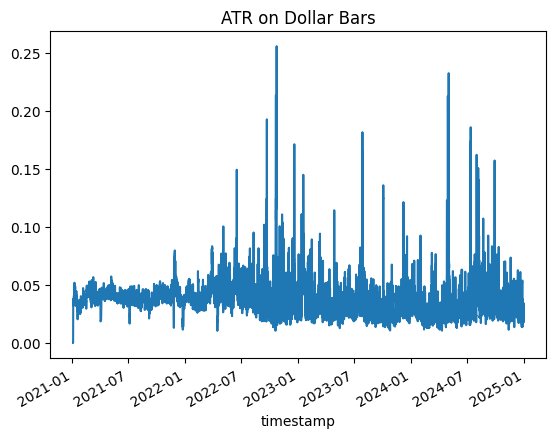

In [18]:
%%time
atr60 = get_atr(df, window=60)
atr60.describe()
atr60.plot(title='ATR on Dollar Bars')

In [19]:
trgt = atr60.reindex(t_events, method='ffill')
trgt.describe()

count    318982.000000
mean          0.039840
std           0.017294
min           0.000000
25%           0.029662
50%           0.036405
75%           0.045004
max           0.255646
Name: atr60, dtype: float64

In [20]:
def get_intraday_vol(log_return, window=60, span=60):
    rolling_std = log_return.rolling(window=window).std()
    smoothed_vol = rolling_std.ewm(span=span).mean()
    return smoothed_vol.rename(f'intraday_vol_{window}_{span}')

In [21]:
intraday_vol = get_intraday_vol(df['log_return'], window=60, span=60)

In [22]:
trgt = intraday_vol.reindex(t_events, method='ffill')
trgt.describe()

count    318951.000000
mean          0.000211
std           0.000108
min           0.000037
25%           0.000147
50%           0.000188
75%           0.000244
max           0.001753
Name: intraday_vol_60_60, dtype: float64

## Apply Triple Barrier
We use daily volatility to calculate TP/SL, and we set our T1 as 1day

In [23]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pandas as pd

def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    
    pt = ptSl[0] * events_['trgt'] if ptSl[0] > 0 else pd.Series(index=events.index)
    sl = -ptSl[1] * events_['trgt'] if ptSl[1] > 0 else pd.Series(index=events.index)

        
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
        
    return out


def parallel_apply(func, items, num_threads=4, **kwargs):
    
    def worker(molecule):
        return func(molecule=molecule, **kwargs)

    chunks = np.array_split(items, num_threads)
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(worker, chunks))

    return pd.concat(results).sort_index()


def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads=4, t1=False, side=None):
    # Step 1: Filter targets
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]

    # Step 2: Set vertical barrier (t1)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)

    # Step 3: Build events DataFrame
    if side is None:
        side_, ptSl_ = pd.Series(1., index=trgt.index), [ptSl[0], ptSl[0]]
    else:
        side_, ptSl_ = side.loc[trgt.index], ptSl[:2]

    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt'])

    # Step 4: Apply barriers in parallel
    df0 = parallel_apply(
        func=applyPtSlOnT1,
        items=events.index,
        num_threads=numThreads,
        close=close,
        events=events,
        ptSl=ptSl_
    )

    # Step 5: Choose the first touched barrier
    events['t1'] = df0.dropna(how='all').min(axis=1)
    
    if side is None:
        events = events.drop('side', axis=1)
        
    return events


In [24]:
def get_vertical_barrier(t_events, close, delta=pd.Timedelta(minutes=60)):
    """
    For each event in t_events, find the timestamp in close.index 
    that is at least delta later. Returns a pd.Series of t1.
    """
    barrier_times = t_events + delta
    t1_idx = close.index.searchsorted(barrier_times)
    valid_idx = t1_idx[t1_idx < len(close)]
    t1 = pd.Series(close.index[valid_idx], index=t_events[:len(valid_idx)])
    return t1

In [25]:
t1 = get_vertical_barrier(t_events, df['close'], delta=pd.Timedelta(minutes=120))

In [26]:
t1

timestamp
2021-01-04 02:39:51.245   2021-01-04 04:50:10.949
2021-01-04 03:10:16.043   2021-01-04 05:14:08.409
2021-01-04 03:35:34.353   2021-01-04 05:50:18.483
2021-01-04 03:46:15.759   2021-01-04 05:50:18.483
2021-01-04 04:22:33.521   2021-01-04 06:33:50.532
                                    ...          
2024-12-30 21:01:16.631   2024-12-30 23:01:33.441
2024-12-30 21:06:58.409   2024-12-30 23:10:19.118
2024-12-30 21:32:33.781   2024-12-30 23:33:37.983
2024-12-30 21:45:09.215   2024-12-30 23:47:00.978
2024-12-30 21:48:03.683   2024-12-30 23:54:00.635
Name: timestamp, Length: 318976, dtype: datetime64[ns]

## Calculate minRet

In [27]:
min_ret = 0.5 * intraday_vol.median()
min_ret

np.float64(8.406785025823263e-05)

In [28]:
%%time

events = getEvents(
    df['close'],
    tEvents=t_events, 
    ptSl=[1,1], 
    trgt=trgt, 
    minRet=0, 
    numThreads=16, 
    t1=t1, 
    side=None
)

CPU times: user 1min 24s, sys: 6.53 s, total: 1min 31s
Wall time: 1min 26s


In [29]:
events

,t1,trgt
timestamp,,
2021-01-04 10:26:20.961,2021-01-04 10:56:22.062,0.000208
2021-01-04 10:56:22.062,2021-01-04 11:26:13.473,0.000211
2021-01-04 11:09:43.139,2021-01-04 11:20:54.785,0.000212
2021-01-04 11:20:54.785,2021-01-04 11:26:13.473,0.000212
2021-01-04 11:26:13.473,2021-01-04 11:47:52.176,0.000212
...,...,...
2024-12-30 23:10:19.118,2024-12-30 23:15:58.082,0.000114
2024-12-30 23:15:58.082,2024-12-30 23:33:37.983,0.000115
2024-12-30 23:36:09.864,2024-12-30 23:37:33.033,0.000115


In [30]:
events

,t1,trgt
timestamp,,
2021-01-04 10:26:20.961,2021-01-04 10:56:22.062,0.000208
2021-01-04 10:56:22.062,2021-01-04 11:26:13.473,0.000211
2021-01-04 11:09:43.139,2021-01-04 11:20:54.785,0.000212
2021-01-04 11:20:54.785,2021-01-04 11:26:13.473,0.000212
2021-01-04 11:26:13.473,2021-01-04 11:47:52.176,0.000212
...,...,...
2024-12-30 23:10:19.118,2024-12-30 23:15:58.082,0.000114
2024-12-30 23:15:58.082,2024-12-30 23:33:37.983,0.000115
2024-12-30 23:36:09.864,2024-12-30 23:37:33.033,0.000115


In [31]:
events['duration'] = events['t1'] - events.index
events['duration'].describe()

count                       318950
mean     0 days 00:07:52.236234538
std      0 days 01:19:14.038724625
min         0 days 00:00:06.879000
25%         0 days 00:01:10.216250
50%         0 days 00:02:31.440500
75%         0 days 00:05:37.809750
max         3 days 00:05:38.765000
Name: duration, dtype: object

In [32]:
longest_idx = events['duration'].idxmax()
longest_event = events.loc[longest_idx]
print(f"Longest event index: {longest_idx}")
print(longest_event)

Longest event index: 2023-12-29 21:55:19.811000
t1          2024-01-01 22:00:58.576000
trgt                          0.000166
duration        3 days 00:05:38.765000
Name: 2023-12-29 21:55:19.811000, dtype: object


# Keep only intraday events

In [33]:
events = events[events.index.date==events.t1.dt.date]

## Create classification labels

In [34]:
def getBins(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    # 2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[
        events_.index] - 1
    if 'side' in events_: out['ret'] *= events_['side']  # meta-labeling
    out['bin'] = np.sign(out['ret'])

    if 'side' not in events_:
        # only applies when not meta-labeling.
        # to update bin to 0 when vertical barrier is touched, we need the
        # original vertical barrier series since the events['t1'] is the time
        # of first touch of any barrier and not the vertical barrier
        # specifically. The index of the intersection of the vertical barrier
        # values and the events['t1'] values indicate which bin labels needs
        # to be turned to 0.
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'bin'] = 0.

    if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0  # meta-labeling
    return out

In [35]:
labels = getBins(events, df['close'], t1=t1)
labels["bin_class"] = labels["bin"] + 1
labels

,ret,bin,bin_class
timestamp,,,
2021-01-04 10:26:20.961,0.000355,0.0,1.0
2021-01-04 10:56:22.062,0.000233,0.0,1.0
2021-01-04 11:09:43.139,-0.000248,-1.0,0.0
2021-01-04 11:20:54.785,0.000292,0.0,1.0
2021-01-04 11:26:13.473,0.000506,1.0,2.0
...,...,...,...
2024-12-30 22:57:51.659,0.000121,1.0,2.0
2024-12-30 23:10:19.118,0.000322,1.0,2.0
2024-12-30 23:15:58.082,0.000118,0.0,1.0


In [36]:
labels.bin.value_counts()

bin
 1.0    107513
 0.0    105506
-1.0    104469
Name: count, dtype: int64

In [37]:
labeled_events = events.join(labels, how='inner')

In [38]:
labeled_events.head()

,t1,trgt,duration,ret,bin,bin_class
timestamp,,,,,,
2021-01-04 10:26:20.961,2021-01-04 10:56:22.062,0.000208,0 days 00:30:01.101000,0.000355,0.0,1.0
2021-01-04 10:56:22.062,2021-01-04 11:26:13.473,0.000211,0 days 00:29:51.411000,0.000233,0.0,1.0
2021-01-04 11:09:43.139,2021-01-04 11:20:54.785,0.000212,0 days 00:11:11.646000,-0.000248,-1.0,0.0
2021-01-04 11:20:54.785,2021-01-04 11:26:13.473,0.000212,0 days 00:05:18.688000,0.000292,0.0,1.0
2021-01-04 11:26:13.473,2021-01-04 11:47:52.176,0.000212,0 days 00:21:38.703000,0.000506,1.0,2.0


In [39]:
df.loc[labeled_events.index]

,open,high,low,close,volume,spread,close_delta,close_return,close_log_return,ret_mean_5,...,month,hour_sin,hour_cos,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos,log_return
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-04 10:26:20.961,102.7245,102.7675,102.7245,102.7600,1.120440e+12,0.001973,0.0350,0.000341,0.000341,0.000026,...,1,0.500000,-0.866025,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025,0.000341
2021-01-04 10:56:22.062,102.7655,102.7965,102.7650,102.7965,1.119950e+12,0.003206,0.0305,0.000297,0.000297,0.000071,...,1,0.500000,-0.866025,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025,0.000297
2021-01-04 11:09:43.139,102.7945,102.8205,102.7885,102.8160,1.127340e+12,0.002834,0.0220,0.000214,0.000214,0.000123,...,1,0.258819,-0.965926,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025,0.000214
2021-01-04 11:20:54.785,102.8150,102.8150,102.7905,102.7905,1.121020e+12,0.003106,-0.0250,-0.000243,-0.000243,0.000048,...,1,0.258819,-0.965926,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025,-0.000243
2021-01-04 11:26:13.473,102.7910,102.8250,102.7905,102.8205,1.121670e+12,0.003029,0.0300,0.000292,0.000292,0.000047,...,1,0.258819,-0.965926,0.0,1.0,0.724793,0.688967,5.000000e-01,0.866025,0.000292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-30 22:57:51.659,156.8815,156.9225,156.8685,156.8900,7.342900e+11,0.079496,0.0090,0.000057,0.000057,0.000025,...,12,-0.500000,0.866025,0.0,1.0,-0.201299,0.979530,-2.449294e-16,1.000000,0.000057
2024-12-30 23:10:19.118,156.9105,156.9640,156.9090,156.9635,7.369500e+11,0.022684,0.0545,0.000347,0.000347,0.000132,...,12,-0.258819,0.965926,0.0,1.0,-0.201299,0.979530,-2.449294e-16,1.000000,0.000347
2024-12-30 23:15:58.082,156.9640,157.0270,156.9575,157.0140,7.367500e+11,0.016922,0.0505,0.000322,0.000322,0.000169,...,12,-0.258819,0.965926,0.0,1.0,-0.201299,0.979530,-2.449294e-16,1.000000,0.000322


## Calculate Concurrency

In [40]:
def get_concurrency(events, price_index):
    """
    Calculate concurrency: number of overlapping events at each time.
    
    Args:
        events (pd.DataFrame): Must have 't1' column with index as start time.
        price_index (pd.DatetimeIndex): Full time index (e.g., from your OHLCV data).
        
    Returns:
        pd.Series: concurrency count indexed by time.
    """
    concurrency = pd.Series(0, index=price_index)

    for start, end in events['t1'].items():
        concurrency[start:end] += 1

    return concurrency


In [41]:
# Let's say your OHLCV data or close series has this index
price_index = df.index  # or df_ohlcv.index

concurrency = get_concurrency(events=labeled_events, price_index=price_index)

(array([7.32224e+05, 9.59270e+04, 3.09300e+03, 4.80000e+02, 2.68000e+02,
        1.14000e+02, 1.80000e+01, 1.30000e+01, 8.00000e+00, 5.00000e+00]),
 array([ 0. ,  2.7,  5.4,  8.1, 10.8, 13.5, 16.2, 18.9, 21.6, 24.3, 27. ]),
 <BarContainer object of 10 artists>)

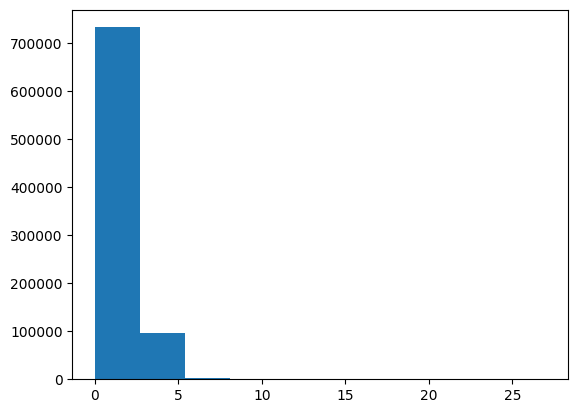

In [42]:
plt.hist(concurrency)

## Save events to disk

In [43]:
labeled_events.to_pickle(DIRECTION_LABEL_FILE_PATH)